### IV. Directed search

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import json

from specify import (specify_levers, specify_scenario, default_scenario)
# from problem_formulation import get_model_for_problem_formulation
from problem_formulation_new_version import get_model_for_problem_formulation

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, ScalarOutcome, Constraint)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging

from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.analysis import parcoords
from ema_workbench import save_results
from ema_workbench import load_results

ema_logging.log_to_stderr(ema_logging.INFO)
BaseEvaluator.reporting_frequency = 0.1
# ema_logging.log_to_stderr(ema_logging.DEBUG)

### 1. Define the problem and scenario

In [37]:
dike_model = get_model_for_problem_formulation(4) # 8 obj PF
n_objectives = 8
# dike_model = get_model_for_problem_formulation(1) # 3 obj PF
# n_objectives = 3
reference_scenario = default_scenario(dike_model) # Default scenario proposed by the author of the model

[MainProcess/INFO] model initialized


### 2. Run MORDM algorithm

#### Introduce constraints

In [ ]:
# # Setting up the thresholds
# deaths_constr = 0.009
# rfr_constr = 1e6 * 350

In [ ]:
# # Defining constraints
# constraints = [Constraint('Expected Number of Deaths Constraint', outcome_names='Expected Number of Deaths',
#                           function=lambda x:max(0, x-deaths_constr)),
#                 Constraint('RfR Total Costs Constraint', outcome_names='RfR Total Costs',
#                           function=lambda x:max(0, x-rfr_constr))]      

In [42]:
eps = pd.read_excel('epsilons_optim_8obj.xlsx')

In [45]:
epsilons = eps[0].values.tolist()
nfe = 1e4
convergence_metrics = [EpsilonProgress()]

start = time.time()
with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilons,
                                              convergence=convergence_metrics,
                                              reference=reference_scenario,
                                              constraints=constraints
                                              )
end = time.time()
print('Optimization time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 300/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 4: 400/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 5: 500/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 

[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 47: 4667/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 48: 4767/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 49: 4866/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 50: 4964/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 51: 5062/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 52: 5161/10000 nfe
[MainProcess/INFO] performing 1 sc

[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 94: 9330/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 95: 9430/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 96: 9530/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 97: 9630/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 98: 9729/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 99: 9829/10000 nfe
[MainProcess/INFO] performin

Optimization time is 24 mintues


In [46]:
print('Found ' + str(len(results)) + ' solutions' + '\n')

Found 1908 solutions



In [ ]:
pd.DataFrame(results).describe()

#### Check convergence

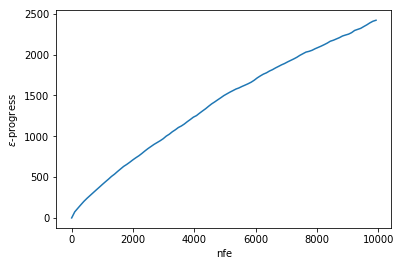

In [47]:
plt.plot(convergence.nfe, convergence.epsilon_progress)
plt.ylabel('$\epsilon$-progress')
plt.xlabel('nfe')
plt.show()

#### Save / load results

In [8]:
dcs_c_name = 'MORDM_dcs_convergence_' + str(int(nfe)) + 'nfe' + '_' + str(n_objectives) + 'obj' + '.xlsx'
dcs_r_name = 'MORDM_dcs_results_' + str(int(nfe)) + 'nfe' + '_' + str(n_objectives) + 'obj' + '.xlsx'

In [9]:
# convergence.to_excel(ds_c_name)
# results.to_excel(ds_r_name)

In [13]:
# results = pd.read_excel(dcs_r_name)
# convergence = pd.read_excel(dcs_c_name)

#### Show optimization trade-offs

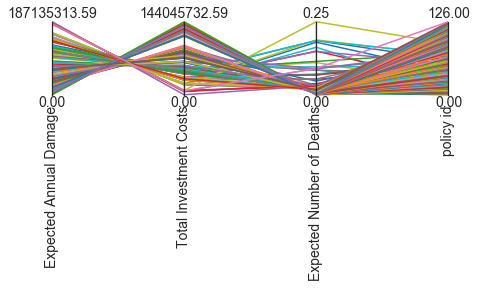

In [14]:
# 
data = results.loc[:, [o.name for o in dike_model.outcomes]]
data['policy id'] = data.index.astype('float64')
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

### 3. Re-evalute the policies

In [15]:
# Introduce a treshold
logical = results['Expected Number of Deaths'] < 0.0005
print('Satisfactory policies found', np.sum(logical))

Satisfactory policies found 5


In [16]:
# Select the policies 
policies = results[logical]
policies = policies.drop([o.name for o in dike_model.outcomes], axis=1).reset_index(drop=True)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
n_policies = len(policies)
# Show the policies
policies

,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,EWS_DaysToThreat
0,2,3,4,4,5,0,0,0,0,0,2
1,2,4,4,4,5,0,0,0,0,0,3
2,2,3,4,1,5,0,0,0,0,0,2
3,2,4,4,3,5,0,0,0,0,0,2
4,2,4,4,0,5,0,0,0,0,0,3


#### Save / load results

In [17]:
# policies.to_excel('MORDM_optimal_polices_dcs.xlsx')
# policies = pd.read_excel('MORDM_optimal_polices_dcs.xlsx')

In [18]:
# Run simulation
start = time.time()
n_scenarios = 5000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)
end = time.time()
print('Simulation time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 5000 scenarios * 5 policies * 1 model(s) = 25000 experiments
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 7500 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 12500 cases completed
[MainProcess/INFO] 15000 cases completed
[MainProcess/INFO] 17500 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] 22500 cases completed
[MainProcess/INFO] 25000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Simulation time is 33 mintues


#### Save / load results

In [19]:
save_results(results, 'MORDM_results_re_evaluating_dcs.tar.gz')
# results = load_results('MORDM_results_re_evaluating_dcs.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\Mikhail\Python projects\Model-based decision-making\final assignment\MORDM_results_re_evaluating_dcs.tar.gz


#### Preprocess results

In [20]:
experiments, outcomes = results
# n_policies = 6
n_scenarios = pd.DataFrame(experiments).shape[0] / n_policies
policies = np.empty([len(experiments), 1])
k = 0
l = n_scenarios
for i in range (len(experiments)) : 
    policies[i] = k
    if (i == l - 1) : 
        k = k + 1
        l = l + n_scenarios
policies = policies.astype(int)

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

#### Visualize results

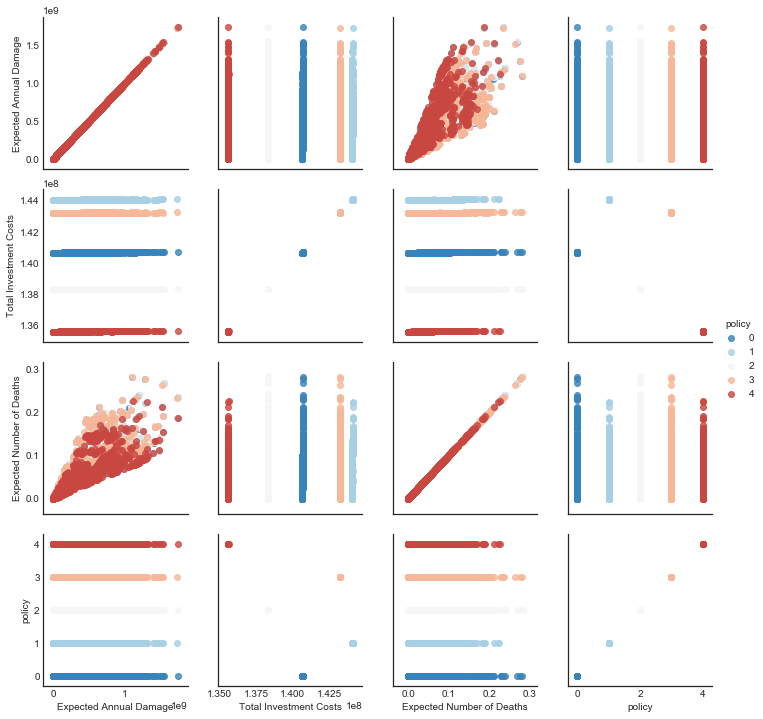

In [21]:
g = sns.PairGrid(data, hue='policy', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

In [ ]:
fig, axs = plt.subplots(figsize=[16,4],ncols=4)
colors = iter(cm.viridis(np.linspace(0, 1, 4)))
for i in range(0, n_policies) : 
    sns.tsplot(data=data[data.policy == int(i)]['Expected Number of Deaths'].reset_index(drop=True), ax=axs[i], legend=True, color=next(colors)).set_title('policy ' + str(i))
    # plt.xlabel('experiments')
    # plt.ylabel('values')

### 4. Measure robusntess 

#### 4.1 Signal-to-noise

In [64]:
def s_to_n(data) : # ,direction):
    mean = np.mean(data)
    std = np.std(data)
    
#     if direction==ScalarOutcome.MAXIMIZE:
#         return mean/std
#     else:
    return mean*std

In [65]:
experiments, outcomes = results

overall_scores = {}

for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes :
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores

scores = pd.DataFrame.from_dict(overall_scores).T

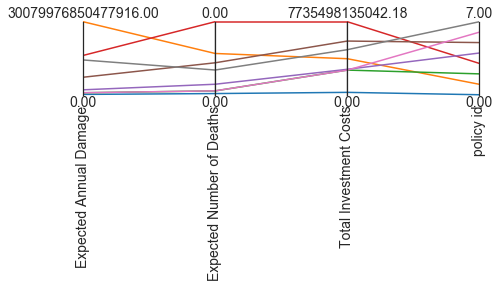

In [66]:
# 
data = scores
data['policy id'] = data.index.astype('float64')
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

#### 4.2 Maximum regret

In [67]:
def calculate_regret(data, best) : 
    return np.abs(best-data)

In [68]:
experiments, outcomes = results

regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario_id":experiments['scenario_id']})
    
    data = data.pivot(index='scenario_id', columns='policy')
    data.columns = data.columns.get_level_values(1)
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    regret[outcome.name] = regret
    max_regret[outcome.name] = outcome_regret.max()

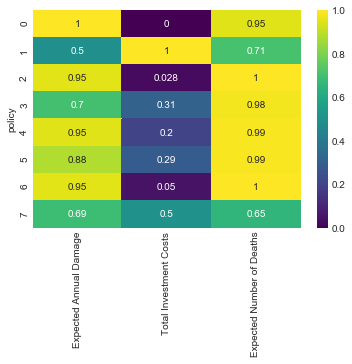

In [69]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

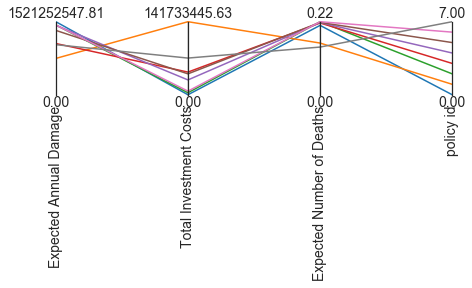

In [70]:
data = max_regret
data['policy id'] = data.index.astype('float64')
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()